### Wall of Imports

In [5]:
import os
import getpass
import requests
import json
from langchain_community.document_loaders import JSONLoader
import pprint
from langchain_text_splitters import RecursiveJsonSplitter
from langchain_qdrant import QdrantVectorStore
from langchain_openai import OpenAIEmbeddings
from qdrant_client import QdrantClient
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import shutil
from ftplib import FTP
import tarfile
from langchain.prompts import ChatPromptTemplate
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough
import subprocess
import pandas
from bs4 import BeautifulSoup
import fnmatch

### Enter OpenAI API Key

In [6]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

### Enter RAGAS API Key

In [4]:
os.environ["RAGAS_APP_TOKEN"] = getpass.getpass("Please enter your Ragas API key!")

### Enter Qdrant API Key

In [7]:
os.environ["QDRANT_API_KEY"] = getpass.getpass("Please enter your Qdrant API key!")

### Retrieve Projects (University of Utah Pediatrics projects only for the time being)

In [8]:
# Define the directory and file path
directory = 'data'
file_path = os.path.join(directory, 'projects_data.json')

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Define the endpoint URL
url = "https://api.reporter.nih.gov/v2/projects/search"

# Define the JSON body for the request
json_body = {
        "criteria":
        {
            "org_names": ["UNIVERSITY OF UTAH"],
            "dept_types": ["PEDIATRICS"]
        },
        "include_fields": [
             "ApplId","SubprojectId","FiscalYear","Organization", "ProjectNum",
             "ProjectNumSplit","ContactPiName","AllText","FullStudySection",
             "ProjectStartDate","ProjectEndDate", "AwardAmount", "ActivityCode", 
             "AgencyIcAdmin", "AwardType", "AwardNoticeDate", "BudgetStart", 
             "BudgetEnd", "CoreProjectNum", "OrganizationType", "OpportunityNumber",
             "AgencyIcFundings", "FundingMechanism", "SpendingCategoriesDesc", "PhrText",
             "PrincipalInvestigators", "PrefTerms", "ProjectTitle", "DirectCostAmt",
             "IndirectCostAmt", "IsActive", "Terms", "AbstractText", "AgencyCode",
             "ProjectDetailUrl"
         ],
         "offset":0,
         "limit":100,
         "sort_field":"project_start_date",
          "sort_order":"desc"
   }

# Make the POST request with JSON body
response = requests.post(url, json=json_body)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    data = response.json()
    
    # Save the JSON data to a file
    
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)  # indent=4 for pretty printing
    # Do something with the data
    #pprint.pprint(data)
else:
    print(f"Request failed with status code {response.status_code}")

### Retrieve Publications (Limited to Projects Retrieved Above)

In [6]:
file_path = os.path.join(directory, 'publications_data.json')
core_proj_nums = ""

for i in range(0, len(data['results'])):
    core_proj_num = data['results'][i]['core_project_num']
    if i == 0:
        core_proj_nums += "\"" + core_proj_num + "\""
    else:
        core_proj_nums += ", \"" + core_proj_num + "\""
    
publications_endpoint = "https://api.reporter.nih.gov/v2/publications/search"

# Define the JSON body for the request
json_body = {
    "criteria": {
        "coreProjectNums": [
        core_proj_nums
        ]
    },
    "offset": 0,
    "limit": 100,
    "sortField": "string",
    "sortOrder": "string"
}

# Make the POST request with JSON body
response = requests.post(publications_endpoint, json=json_body)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    publications_data = response.json()
    #pprint.pprint(publications_data)
    
    # Save the JSON data to a file
    
    with open(file_path, 'w') as file:
        json.dump(publications_data, file, indent=4)  # indent=4 for pretty printing
    # Do something with the data
    #pprint.pprint(data)
else:
    print(f"Request failed with status code {response.status_code}")

### Retrieve PMCID (for retrieving FHS download link)

In [7]:
def retrieve_pmcid(pmid):
    base_url = "https://pubmed.ncbi.nlm.nih.gov/"
    url = base_url + str(pmid)
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract publication from the webpage
        pmcid = soup.find('a', attrs={'class': 'id-link', 'data-ga-action': 'PMCID'}).get_text(strip="true")
        
        # Print the extracted text
        return pmcid
    else:
        print(f"Failed to retrieve webpage. Status code: {response.status_code}")

In [8]:
pmcid = retrieve_pmcid(32191811)
print(pmcid)

PMC7081964


### Retrieve FHS Link (for downloading publication)

In [9]:
def retrieve_ftp_link(pmcid):
    url = "https://www.ncbi.nlm.nih.gov/pmc/utils/oa/oa.fcgi?id=" + pmcid
    response = requests.get(url)
    
    # Check if the request was successful
    if response.status_code == 200:
        # Parse the XML content
        root = ET.fromstring(response.content)

        # Find the link
        ftp_link = None
        for link in root.findall(".//link"):
            if link.get('format') == 'tgz':
                ftp_link = link.get('href')
                break

        return ftp_link

In [10]:
ftp_link = retrieve_ftp_link(pmcid)
print(ftp_link)

ftp://ftp.ncbi.nlm.nih.gov/pub/pmc/oa_package/c4/64/PMC7081964.tar.gz


### Retrieve Publication

In [11]:
def retrieve_publication(ftp_link):
    modified_ftp_link = ftp_link.replace("ftp://", "")
    
    # FTP server details
    ftp_server = modified_ftp_link[0:modified_ftp_link.find("/")]
    reversed_ftp_link = modified_ftp_link[::-1]
    file_to_download = reversed_ftp_link[0:reversed_ftp_link.find("/")][::-1]
    ftp_directory = (modified_ftp_link.replace(ftp_server, "")).replace(f"/{file_to_download}", "")
    local_directory = "data"
    local_file_path = os.path.join(local_directory, file_to_download)

    ftp = FTP(ftp_server)
    ftp.login()
    ftp.cwd(ftp_directory)
    with open(local_file_path, 'wb') as local_file:
        ftp.retrbinary(f"RETR {file_to_download}", local_file.write)
    ftp.close()

    # Open the tar.gz file
    with tarfile.open(local_file_path, 'r:gz') as tar_ref:
        # Extract all contents to the specified directory
        tar_ref.extractall("data")
        
    # Check if the file exists
    if os.path.exists(local_file_path):
        # Delete the file
        os.remove(local_file_path)

In [353]:
retrieve_publication(ftp_link)

/var/folders/53/qt49q2y578gf4p14hcjbpshc0000gn/T/ipykernel_9255/2942949143.py:22: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar_ref.extractall("data")


### Clean Up Publications

In [4]:
def clean_up_publications(directory_path):
    # Check if the parent directory exists
    if os.path.exists(directory_path):
        # Iterate over all entries in the parent directory
        for entry in os.listdir(directory_path):
            entry_path = os.path.join(directory_path, entry)
            
            # Check if the entry is a directory
            if os.path.isdir(entry_path) and entry != 'Opportunities':
                # Remove the subdirectory and all its contents
                shutil.rmtree(entry_path)
                print(f"Subdirectory '{entry_path}' has been deleted.")

In [5]:
directory_path = "data"

clean_up_publications(directory_path)

Subdirectory 'data/PMC7081964' has been deleted.


### Load Funding Opportunities (no API access sadly)

In [46]:
from langchain.document_loaders import CSVLoader

# Path to your CSV file
csv_file_path = "data/Opportunities/NIH_Funding_Opportunities_20250221.csv"

# Load CSV file as LangChain documents
loader = CSVLoader(file_path=csv_file_path)
opportunities_summary = loader.load()

print(opportunities_summary[0:10])
len(opportunities_summary)

[Document(metadata={'source': 'data/Opportunities/NIH_Funding_Opportunities_20250221.csv', 'row': 0}, page_content='Title: Intervention Research to Improve Native American Health (R34 Clinical Trial Optional)\nRelease_Date: 1/22/2025\nExpired_Date: 1/8/2027\nActivity_Code: R34\nParent_Organization: NIH\nOrganization: NIDA\nParticipating_Orgs: NCCIH, NIA, NIAAA, NICHD, NIDCR, NIEHS, NIMH, NINR, OBSSR, ODP, ORWH, THRO\nDocument_Number: PAR-25-378\nDocument_Type: PAR\nClinical_Trials: Optional\nURL: https://grants.nih.gov/grants/guide/pa-files/PAR-25-378.html'), Document(metadata={'source': 'data/Opportunities/NIH_Funding_Opportunities_20250221.csv', 'row': 1}, page_content='Title: New Investigator Gateway Awards for Collaborative T1D Research (R03 Clinical Trial Not Allowed)\nRelease_Date: 1/22/2025\nExpired_Date: 3/7/2026\nActivity_Code: R03\nParent_Organization: NIH\nOrganization: NIDDK\nParticipating_Orgs: OD\nDocument_Number: RFA-DK-26-009\nDocument_Type: RFA\nClinical_Trials: Not_Al

528

In [52]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

url = "https://e788c0ea-f5df-4d96-85ac-350da677aadf.us-west-2-0.aws.cloud.qdrant.io"

opportunities_summary_qdrant = QdrantVectorStore.from_documents(
    opportunities_summary,
    embeddings,
    url=url,
    prefer_grpc=False,
    api_key=os.environ["QDRANT_API_KEY"],
    collection_name="opportunities_summary",
)

In [50]:
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatOpenAI

llm = ChatOpenAI(model_name="gpt-4o-mini")  # Use GPT-4 or any other model
summarizer = load_summarize_chain(llm, chain_type="map_reduce")

summary = summarizer.invoke(opportunities_summary[0:10])

# Print summary
print(summary)

{'input_documents': [Document(metadata={'source': 'data/Opportunities/NIH_Funding_Opportunities_20250221.csv', 'row': 0}, page_content='Title: Intervention Research to Improve Native American Health (R34 Clinical Trial Optional)\nRelease_Date: 1/22/2025\nExpired_Date: 1/8/2027\nActivity_Code: R34\nParent_Organization: NIH\nOrganization: NIDA\nParticipating_Orgs: NCCIH, NIA, NIAAA, NICHD, NIDCR, NIEHS, NIMH, NINR, OBSSR, ODP, ORWH, THRO\nDocument_Number: PAR-25-378\nDocument_Type: PAR\nClinical_Trials: Optional\nURL: https://grants.nih.gov/grants/guide/pa-files/PAR-25-378.html'), Document(metadata={'source': 'data/Opportunities/NIH_Funding_Opportunities_20250221.csv', 'row': 1}, page_content='Title: New Investigator Gateway Awards for Collaborative T1D Research (R03 Clinical Trial Not Allowed)\nRelease_Date: 1/22/2025\nExpired_Date: 3/7/2026\nActivity_Code: R03\nParent_Organization: NIH\nOrganization: NIDDK\nParticipating_Orgs: OD\nDocument_Number: RFA-DK-26-009\nDocument_Type: RFA\nCli

In [51]:
pprint.pprint(summary)

{'input_documents': [Document(metadata={'source': 'data/Opportunities/NIH_Funding_Opportunities_20250221.csv', 'row': 0}, page_content='Title: Intervention Research to Improve Native American Health (R34 Clinical Trial Optional)\nRelease_Date: 1/22/2025\nExpired_Date: 1/8/2027\nActivity_Code: R34\nParent_Organization: NIH\nOrganization: NIDA\nParticipating_Orgs: NCCIH, NIA, NIAAA, NICHD, NIDCR, NIEHS, NIMH, NINR, OBSSR, ODP, ORWH, THRO\nDocument_Number: PAR-25-378\nDocument_Type: PAR\nClinical_Trials: Optional\nURL: https://grants.nih.gov/grants/guide/pa-files/PAR-25-378.html'),
                     Document(metadata={'source': 'data/Opportunities/NIH_Funding_Opportunities_20250221.csv', 'row': 1}, page_content='Title: New Investigator Gateway Awards for Collaborative T1D Research (R03 Clinical Trial Not Allowed)\nRelease_Date: 1/22/2025\nExpired_Date: 3/7/2026\nActivity_Code: R03\nParent_Organization: NIH\nOrganization: NIDDK\nParticipating_Orgs: OD\nDocument_Number: RFA-DK-26-009\nDo

In [10]:
# Limit opportunity count
opportunity_count = 10

# Path to the CSV file
csv_file_path = "data/Opportunities/NIH_Funding_Opportunities_20250221.csv"

# Load the CSV data into a DataFrame
df = pandas.read_csv(csv_file_path)

# Extract the html files 
counter = 0

for index, row in df.iterrows():
    output_file = "data/Opportunities/" + row['Document_Number'] + ".html"
    # Construct the curl command
    curl_command = [
        "curl",
        "-X", "GET",  # or "POST", "PUT", etc.
        row['URL'],
        "-o", output_file
    ]
    
    # Execute the curl command
    try:
        result = subprocess.run(curl_command, check=True, text=True, capture_output=True)
    except subprocess.CalledProcessError as e:
        print("An error occurred:", e)
        
    counter += 1
    
    # Limit to opportunity count
    if counter > opportunity_count:
        break

### Create HTML splitter

In [11]:
from langchain_text_splitters import HTMLSectionSplitter

headers_to_split_on = [("h1", "Header 1"), ("h2", "Header 2"), ("h3", "Header 3")]

html_splitter = HTMLSectionSplitter(
    headers_to_split_on=headers_to_split_on
)

### Clean up HTML files and split (for the golden chunks)

In [16]:
# Path to the directory containing HTML files
directory_path = "data/Opportunities"

def clean_html(html_raw):
    soup = BeautifulSoup(html_raw.replace("\n", "").replace("\t", ""), 'html.parser')
    # Remove div tags (could use some more work)
    for div_tag in soup.find_all('div'):
        div_tag.replaceWithChildren()
    # Remove script tags 
    for script in soup.find_all('script'):
        script.decompose()
    # Remove title tags
    for title in soup.find_all('title'):
        opportunity_title = title.string
        title.decompose()
    # Remove meta tags 
    for meta in soup.find_all('meta'):
        meta.decompose()
    # Add metadata to header tags 
    for header in soup.find_all(['h1', 'h2', 'h3']):
        if header.string is not None:
            header.string.replace_with(f"{opportunity_title} {header.string}")
    # Return clean file
    return soup.prettify() 

# Initialize opportunities document list
opportunities = []

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    # Check if the file is an HTML file
    if fnmatch.fnmatch(filename, '*.html'):
        file_path = os.path.join(directory_path, filename)
        #Read html file
        with open(file_path, 'r') as f:
            html_raw = f.read()
        #Add cleaned and chunked html file to opportunities list
        opportunities.extend(html_splitter.split_text(clean_html(html_raw)))

In [23]:
len(opportunities)

2446

In [29]:
for row in opportunities:
    if 'Header 1' in row.metadata:
        row.page_content = row.metadata['Header 1'] + ' ' + row.page_content
    elif 'Header 2' in row.metadata:
        row.page_content = row.metadata['Header 2'] + ' ' + row.page_content
    elif 'Header 3' in row.metadata:
        row.page_content = row.metadata['Header 3'] + ' ' + row.page_content

In [40]:
opportunities = [doc for doc in opportunities if doc.metadata.get('Header 1') != '#TITLE#']

In [41]:
pprint.pprint(opportunities[0:10])

[Document(metadata={'Header 1': 'PAR-25-377: Unveiling Health and Healthcare Disparities in Non-Communicable and Chronic Diseases in Latin America: Setting the Stage for Better Health Outcomes Across the Hemisphere (R01 - Clinical Trials Not Allowed) Part 1. Overview Information'}, page_content="PAR-25-377: Unveiling Health and Healthcare Disparities in Non-Communicable and Chronic Diseases in Latin America: Setting the Stage for Better Health Outcomes Across the Hemisphere (R01 - Clinical Trials Not Allowed) Part 1. Overview Information PAR-25-377: Unveiling Health and Healthcare Disparities in Non-Communicable and Chronic Diseases in Latin America: Setting the Stage for Better Health Outcomes Across the Hemisphere (R01 - Clinical Trials Not Allowed) Part 1. Overview Information\n    \n \n \n   Participating Organization(s)\n    \n    National Institutes of Health (\n     \n     NIH\n     \n    )\n    \n \n \n   Components of Participating Organizations\n    \n    National Institute o

In [42]:
opportunities[0].page_content

"PAR-25-377: Unveiling Health and Healthcare Disparities in Non-Communicable and Chronic Diseases in Latin America: Setting the Stage for Better Health Outcomes Across the Hemisphere (R01 - Clinical Trials Not Allowed) Part 1. Overview Information PAR-25-377: Unveiling Health and Healthcare Disparities in Non-Communicable and Chronic Diseases in Latin America: Setting the Stage for Better Health Outcomes Across the Hemisphere (R01 - Clinical Trials Not Allowed) Part 1. Overview Information\n    \n \n \n   Participating Organization(s)\n    \n    National Institutes of Health (\n     \n     NIH\n     \n    )\n    \n \n \n   Components of Participating Organizations\n    \n    National Institute on Minority Health and Health Disparities (\n     \n     NIMHD\n     \n    )\n     \n \n     National Institute on Aging (\n      \n      NIA\n      \n     )\n     \n \n     National Institute of Dental and Craniofacial Research (\n      \n      NIDCR\n      \n     )\n     \n \n     National Inst

### Clean Up HTML Files

In [12]:
def clean_up_html_files(directory_path):
    # Iterate over each file in the directory
    for filename in os.listdir(directory_path):
        # Check if the file is an HTML file
        if fnmatch.fnmatch(filename, '*.html'):
            file_path = os.path.join(directory_path, filename)
            # Delete the HTML file
            os.remove(file_path)
            print(f"Deleted file: {file_path}")

In [13]:
# Path to the directory containing HTML files
directory_path = "data/Opportunities"

clean_up_html_files(directory_path)

Deleted file: data/Opportunities/RFA-AI-24-079.html
Deleted file: data/Opportunities/RFA-DK-26-007.html
Deleted file: data/Opportunities/RFA-FD-25-007.html
Deleted file: data/Opportunities/RFA-HL-26-009.html
Deleted file: data/Opportunities/PAR-25-353.html
Deleted file: data/Opportunities/RFA-HL-26-011.html
Deleted file: data/Opportunities/RFA-HL-26-010.html
Deleted file: data/Opportunities/PAR-25-352.html
Deleted file: data/Opportunities/PAR-25-379.html
Deleted file: data/Opportunities/PAR-25-378.html
Deleted file: data/Opportunities/RFA-DK-26-009.html


### Load Projects
Reference: https://python.langchain.com/v0.2/docs/how_to/document_loader_json/

In [10]:
loader = JSONLoader(
    file_path='data/projects_data.json',
    jq_schema='.results[]',
    text_content=False)

projects = loader.load()

pprint.pprint(projects)

[Document(metadata={'source': '/Users/christinemahler/Desktop/AIE5/Midterm/data/projects_data.json', 'seq_num': 1}, page_content='{"appl_id": 10985653, "subproject_id": null, "fiscal_year": 2024, "project_num": "1K23HD113825-01A1", "organization": {"org_name": "UNIVERSITY OF UTAH", "city": null, "country": null, "org_city": "SALT LAKE CITY", "org_country": "UNITED STATES", "org_state": "UT", "org_state_name": null, "dept_type": "PEDIATRICS", "fips_country_code": null, "org_duns": ["009095365"], "org_ueis": ["LL8GLEVH6MG3"], "primary_duns": "009095365", "primary_uei": "LL8GLEVH6MG3", "org_fips": "US", "org_ipf_code": "514002", "org_zipcode": "841129049", "external_org_id": 514002}, "award_type": "1", "activity_code": "K23", "award_amount": 167455, "is_active": true, "project_num_split": {"appl_type_code": "1", "activity_code": "K23", "ic_code": "HD", "serial_num": "113825", "support_year": "01", "full_support_year": "01A1", "suffix_code": "A1"}, "principal_investigators": [{"profile_id"

### JSON Splitter (not sure if this is needed)

In [22]:
splitter = RecursiveJsonSplitter(max_chunk_size=300)

# Recursively split json data - If you need to access/manipulate the smaller json chunks
json_chunks = splitter.split_json(json_data=data)

for chunk in json_chunks[:3]:
    print(chunk)

NameError: name 'data' is not defined

### Load Projects into Vector Store

In [12]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

projects_qdrant = QdrantVectorStore.from_documents(
    projects,
    embeddings,
    url=url,
    prefer_grpc=False,
    api_key=os.environ["QDRANT_API_KEY"],
    collection_name="projects",
)

ResponseHandlingException: timed out

### Test Similarity Search

In [11]:
query = "What is PA-20-206"
found_docs = projects_qdrant.similarity_search(query, k=1)
pprint.pprint(found_docs)

NameError: name 'projects_qdrant' is not defined

### Create Projects Retriever (change k value as needed)

In [17]:
projects_retriever = projects_qdrant.as_retriever(search_kwargs={"k": 2})

### Create Projects Prompt Template

In [18]:
projects_rag_prompt_template = """\
Use the provide context to answer the provided user question. Only use the provided context to answer the question. If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

projects_rag_prompt = ChatPromptTemplate.from_template(projects_rag_prompt_template)

### Instantiate Chat Model

In [19]:
from langchain_openai.chat_models import ChatOpenAI

projects_llm = ChatOpenAI(model="gpt-4o-mini", tags=["projects_llm"])

### Create Projects RAG Chain

In [20]:
projects_rag_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | projects_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": projects_rag_prompt | projects_llm, "context": itemgetter("context")}
)

In [21]:
!pip install -qU grandalf

In [22]:
print(projects_rag_chain.get_graph().draw_ascii())

          +---------------------------------+      
          | Parallel<context,question>Input |      
          +---------------------------------+      
                    **            **               
                  **                **             
                **                    **           
         +--------+                     **         
         | Lambda |                      *         
         +--------+                      *         
              *                          *         
              *                          *         
              *                          *         
  +----------------------+          +--------+     
  | VectorStoreRetriever |          | Lambda |     
  +----------------------+          +--------+     
                    **            **               
                      **        **                 
                        **    **                   
          +----------------------------------+     
          | 

In [23]:
response = projects_rag_chain.invoke({"question" : "assess the study design complexity for the PA-20-206 opportunity"})

In [24]:
pprint.pprint(response["response"].content)

('The study design complexity for the PA-20-206 opportunity involves several '
 'key aspects:\n'
 '\n'
 '1. **Focus on Differences of Sex Development (DSD)**: The study aims to '
 'explore the decisional needs of adolescents and young adults with DSD, which '
 'inherently involves understanding a complex and sensitive topic that '
 'includes biological, psychological, and social dimensions.\n'
 '\n'
 '2. **Shared Decision Making Framework**: The project incorporates shared '
 'decision making (SDM) principles, which adds complexity as it requires the '
 'development and implementation of tools that facilitate this process between '
 'patients, caregivers, and healthcare providers.\n'
 '\n'
 '3. **Development of Decision Aids (DAs)**: The creation of evidence-based '
 'decision aids for surgical decisions necessitates rigorous research and '
 'design processes to ensure that the tools are effective and cater to the '
 'specific needs of the target population.\n'
 '\n'
 '4. **Pilot Testi

In [58]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content='{"appl_id": 10985653, "subproject_id": null, "fiscal_year": 2024, "project_num": "1K23HD113825-01A1", "organization": {"org_name": "UNIVERSITY OF UTAH", "city": null, "country": null, "org_city": "SALT LAKE CITY", "org_country": "UNITED STATES", "org_state": "UT", "org_state_name": null, "dept_type": "PEDIATRICS", "fips_country_code": null, "org_duns": ["009095365"], "org_ueis": ["LL8GLEVH6MG3"], "primary_duns": "009095365", "primary_uei": "LL8GLEVH6MG3", "org_fips": "US", "org_ipf_code": "514002", "org_zipcode": "841129049", "external_org_id": 514002}, "award_type": "1", "activity_code": "K23", "award_amount": 167455, "is_active": true, "project_num_split": {"appl_type_code": "1", "activity_code": "K23", "ic_code": "HD", "serial_num": "113825", "support_year": "01", "full_support_year": "01A1", "suffix_code": "A1"}, "principal_investigators": [{"profile_id": 12163589, "first_name": "Kristina", "middle_name": "Irene", "last_name": "Suorsa-Johnson", "is_contact_pi

### Load Opportunities Vector Store

In [19]:
from langchain_huggingface import HuggingFaceEmbeddings

finetune_embeddings = HuggingFaceEmbeddings(model_name="christinemahler/aie5-midterm")

/Users/christinemahler/Desktop/AIE5/Midterm/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertModel were not initialized from the model checkpoint at christinemahler/aie5-midterm and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
url = "https://e788c0ea-f5df-4d96-85ac-350da677aadf.us-west-2-0.aws.cloud.qdrant.io"

opportunities_qdrant = QdrantVectorStore.from_documents(
    opportunities,
    finetune_embeddings,
    url=url,
    prefer_grpc=False,
    api_key=os.environ["QDRANT_API_KEY"],
    collection_name="opportunities",
)

### Test Similarity Search

In [21]:
query = "What is NCDDG"
found_docs = opportunities_qdrant.similarity_search(query, k=5)
pprint.pprint(found_docs)

[Document(metadata={'Header 1': 'PAR-25-353: National Cooperative Drug/Device Discovery/Development Groups (NCDDG) for the Treatment of Mental Disorders (U19 Clinical Trial Optional) Part 2. Full Text of Announcement', '_id': '8e80b9e1-b60c-466c-bbbb-0319a80f8709', '_collection_name': 'opportunities'}, page_content='PAR-25-353: National Cooperative Drug/Device Discovery/Development Groups (NCDDG) for the Treatment of Mental Disorders (U19 Clinical Trial Optional) Part 2. Full Text of Announcement'),
 Document(metadata={'Header 1': 'PAR-25-352: National Cooperative Drug/Device Discovery/Development Groups (NCDDG) for the Treatment of Mental Disorders (U01 Clinical Trial Optional) Part 2. Full Text of Announcement', '_id': '8584a02b-5afc-430b-8247-507a142be92a', '_collection_name': 'opportunities'}, page_content='PAR-25-352: National Cooperative Drug/Device Discovery/Development Groups (NCDDG) for the Treatment of Mental Disorders (U01 Clinical Trial Optional) Part 2. Full Text of Announ

### Create Opportunities Retriever

In [22]:
opportunities_retriever = opportunities_qdrant.as_retriever(search_kwargs={"k": 2})

### Create Opportunities Retriever Node

In [23]:
def retrieve(state):
  retrieved_docs = opportunities_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

### Create Opportunities RAG

In [1]:
opportunities_rag_prompt_template = """\
Use the provided context to answer the user's question. Only use the provided context to answer the question.

If the user asks you to provide a list of opportunities, provide a list with the unique id, title, funding type, application due date, and a link to the funding page.

If the user asks you to evaluate the study complexity, provide a complexity score of high, medium, or low and a reason for all of the following categories:
1) Regulatory and Compliance (rank higher if study requires compliance with multiple regulations and provide examples)
2) Data Collection and Management (identify data elements needed, data complexity, data sensitivity, and data collection frequency)
3) Statistical Analysis and Manuscript Development (provide examples)
4) Information Technology (identify data collection services and equipment needed along with software licenses and subscriptions)
5) Operational (includes project administration and site onboarding, coordination and training)
6) Financial (includes budget management and effort allocation over entire duration of project; rank higher if more resources are required)

If you do not know the answer, or it's not contained in the provided context response with "I don't know"

Context:
{context}

Question:
{question}
"""

opportunities_rag_prompt = ChatPromptTemplate.from_template(opportunities_rag_prompt_template)

NameError: name 'ChatPromptTemplate' is not defined

### Initialize Opportunities Chat Model

In [25]:
from langchain_openai.chat_models import ChatOpenAI

opportunities_llm = ChatOpenAI(model="gpt-4o-mini", tags=["opportunities_llm"])

### Create Opportunities Generate Node

In [26]:
def generate(state):
  docs_content = "\n\n".join(doc.page_content for doc in state["context"])
  messages = opportunities_rag_prompt.format_messages(question=state["question"], context=docs_content)
  response = opportunities_llm.invoke(messages)
  return {"response" : response.content}

### Initialize LangGraph

In [27]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

class State(TypedDict):
  question: str
  context: List[Document]
  response: str

### Add Retrieve and Generate Nodes

In [28]:
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

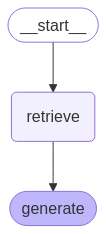

In [29]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Test LangGraph RAG

In [30]:
response = graph.invoke({"question" : "evaluate the study complexity of the PAR-25-353 funding opportunity"})

### Print Response

In [ ]:
pprint.pprint(response["response"])

### Agent Time

In [ ]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

opportunities_rag_chain = (
    {"context": itemgetter("question") | opportunities_retriever, "question": itemgetter("question")}
    | opportunities_rag_prompt | opportunities_llm | StrOutputParser()
)

In [ ]:
opportunities_rag_chain.invoke({"question" : "evaluate the study complexity of the PAR-25-353 funding opportunity"})

In [ ]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_opportunities_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about the NIH funding opportunties"""
  return opportunities_rag_chain.invoke({"question" : query})

In [ ]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

### Agent Node Creator Helper Function

In [ ]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [ ]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}.")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [ ]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [ ]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

In [ ]:
llm = ChatOpenAI(model="gpt-4-turbo")

In [ ]:
opportunities_agent = create_agent(
    llm,
    [retrieve_opportunities_information],
    "You are a research assistant who can provide specific information on funding opportunties. You must only respond with information about the opportunities related to the request.",
)
research_node = functools.partial(agent_node, agent=opportunities_agent, name="OpportunitiesInformationRetriever")

In [ ]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  OpportunitiesInformationRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["OpportunitiesInformationRetriever"],
)

In [ ]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("OpportunitiesInformationRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

In [ ]:
research_graph.add_edge("OpportunitiesInformationRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"OpportunitiesInformationRetriever": "OpportunitiesInformationRetriever", "FINISH": END},
)

In [ ]:
research_graph.set_entry_point("supervisor")
chain = research_graph.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [ ]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | chain

In [ ]:
for s in research_chain.stream(
    "What are the main takeaways from the paper `Extending Llama-3's Context Ten-Fold Overnight'? Please use Search and PaperInformationRetriever!", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('/content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('/content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [ ]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

In [ ]:
budget_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing budget documents based on the following template.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document],
    ("You are an expert senior researcher tasked with writing a LinkedIn post outline and"
    " taking notes to craft a LinkedIn post.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

### Ragas Evaluation

In [42]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [44]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(opportunities, testset_size=10)

Applying HeadlineSplitter:   0%|          | 0/132 [00:00<?, ?it/s]          unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to apply transformation: 'headlines' property not found in this node
unable to ap

In [45]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What is the AADCRC program and how does it con...,[Objectives and Scope The objective of this NO...,The AADCRC program aims to improve the underst...,single_hop_specifc_query_synthesizer
1,What role does a Scientific Core play in the A...,[AADCRC components Administrative Core (requir...,A Scientific Core in the AADCRC structure is o...,single_hop_specifc_query_synthesizer
2,Wht r the eligiblity critera for Alaskaa Nativ...,[RFA-AI-24-079: Asthma and Allergic Diseases C...,Alaska Native and Native Hawaiian Serving Inst...,single_hop_specifc_query_synthesizer
3,Wht are the eligibilty critera for NIH IPF num...,[Eligible Individuals (Program Director/Princi...,"Only one application per institution, identifi...",single_hop_specifc_query_synthesizer
4,What is the role of the Clinical Core in suppo...,"[Administrative Core: required, 1 Data Steward...",The Clinical Core is optional and can have a m...,single_hop_specifc_query_synthesizer
5,What is the role of the Data and Safety Monito...,"[When involving human subjects research, clini...","For all clinical trials, NIAID will provide a ...",single_hop_specifc_query_synthesizer
6,Wht is the role of ASSIST in the clinical core...,[of the Overall component. Note : Specific det...,ASSIST screens will show an asterisk for the P...,single_hop_specifc_query_synthesizer
7,What go in appendix?,"[alternative approaches to be implemented, if ...",Only limited items are allowed in the Appendix...,single_hop_specifc_query_synthesizer
8,Wht is NIAID's role in clinical trials?,[Apply- Application Guide must be followed. De...,"For all clinical trials, NIAID will provide a ...",single_hop_specifc_query_synthesizer
9,What is System for Award Management and why it...,"[protocol development, the plan for study impl...",The System for Award Management (SAM) is a req...,single_hop_specifc_query_synthesizer


In [46]:
dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/0842bbec-e388-4a45-8e5f-faf4950361f9


'https://app.ragas.io/dashboard/alignment/testset/0842bbec-e388-4a45-8e5f-faf4950361f9'

In [47]:
for test_row in dataset:
  response = graph.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [48]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [49]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [50]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:  75%|███████▌  | 45/60 [06:00<02:06,  8.45s/it]Exception raised in Job[10]: TimeoutError()
Exception raised in Job[11]: TimeoutError()
Exception raised in Job[47]: RateLimitError(Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-fG4XzykR5yuSt2Wp6ZlK7gAJ on tokens per min (TPM): Limit 30000, Requested 43568. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}})
Evaluating:  87%|████████▋ | 52/60 [06:49<00:54,  6.78s/it]/Users/christinemahler/Desktop/AIE5/Midterm/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/christinemahler/Desktop/AIE5/Midterm/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  r

{'context_recall': 0.5000, 'faithfulness': 0.3056, 'factual_correctness': 0.6250, 'answer_relevancy': 0.3755, 'context_entity_recall': 0.3567, 'noise_sensitivity_relevant': 0.0667}